In [0]:
import os
outdir = './p1'

In [0]:
if not os.path.exists(outdir):
    os.mkdir(outdir)

In [3]:
import urllib
urllib.request.urlretrieve('http://140.114.76.113:8000/pA1.csv', os.path.join(outdir, 'pA1.csv'))
urllib.request.urlretrieve('http://140.114.76.113:8000/pA2.csv', os.path.join(outdir, 'pA2.csv'))

('./p1/pA2.csv', <http.client.HTTPMessage at 0x7fee62bcaf28>)

In [0]:
import numpy as np
import pandas as pd

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader

In [0]:
seed = 999
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [0]:
class Data:
    def __init__(self, csv_path):
        super().__init__()
        self.anns = pd.read_csv(csv_path).to_dict('records')

    def __len__(self):
        return len(self.anns)

    def __getitem__(self, idx):
        ann = self.anns[idx]
        x = torch.tensor(ann['x'])
        y = torch.tensor(ann['y'])
        return x, y


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.a = nn.Parameter(torch.rand(1) * 0.001)
        self.b = nn.Parameter(torch.rand(1) * 0.001)
    
    def forward(self, xs):
        ps = self.a * xs + self.b
        return ps
    
data = Data(os.path.join(outdir, 'pA1.csv'))
# print(data.anns)
loader = DataLoader(data, batch_size=5)

criterion = nn.L1Loss()

In [0]:
step = 0.1
start = -1
stop = 6
a = np.arange(start, stop, step)
b = np.arange(start, stop, step)
[aa, bb] = np.meshgrid(a, b)
data_len = len(data)
xall = np.zeros(data_len, dtype=np.float32)
yall = np.zeros(data_len, dtype=np.float32)
for i in range(data_len):
    xall[i], yall[i] = data[i]
loss_all = np.zeros(aa.shape)
for ii in range(aa.shape[0]):
    for jj in range(aa.shape[1]):
        pall = aa[ii, jj] * xall + bb[ii, jj]
        loss = np.mean(np.abs(yall-pall))
        loss_all[ii, jj] = loss

In [0]:
device = 'cuda'
model = Net().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-1)

In [9]:
history = {
    'loss': [],
    'a': [],
    'b': []
}

for epoch in range(100):
    for xs, ys in iter(loader):
        
        xs = xs.to(device)
        ys = ys.to(device)

        optimizer.zero_grad()
        ps = model(xs)
        loss = criterion(ps, ys)
        loss.backward()
        optimizer.step()

        history['loss'].append(loss.detach().item())
        history['a'].append(model.a.item())
        history['b'].append(model.b.item())

print(model.a)
print(model.b)

Parameter containing:
tensor([5.0513], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([4.0189], device='cuda:0', requires_grad=True)


In [0]:
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm


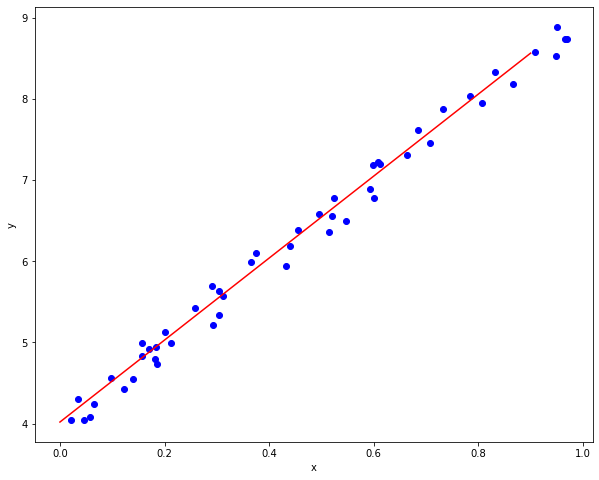

In [11]:
plt.figure(0, figsize=(10, 8))
for i in range(len(data)):
    x, y = data[i]
    plt.plot(x, y, 'bo')
x = np.arange(0, 1, 0.1)
plt.xlabel('x')
plt.ylabel('y')
plt.plot(x, model.a.item() * x + model.b.item(), 'r')

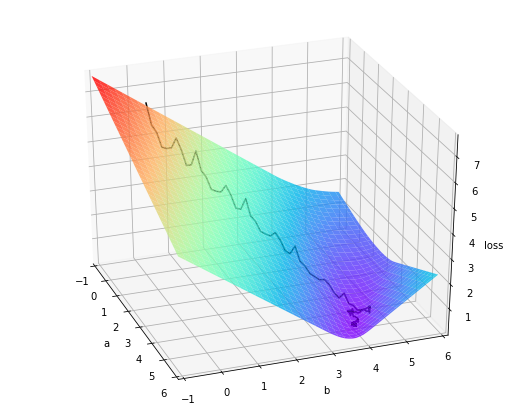

In [12]:
fig = plt.figure(1, figsize=(7,5.6))
ax = Axes3D(fig)
ax.set_xlabel('a')
ax.set_ylabel('b')
ax.set_zlabel('loss')
ax.set_xlim([-1, 6])
ax.set_ylim([-1, 6])
ax.view_init(azim=340)
ax.plot_surface(aa, bb, loss_all, cmap=cm.rainbow, alpha=0.8)
ax.plot(history['a'], history['b'], history['loss'], color='k')

In [13]:
seed = 999
torch.manual_seed(seed)

In [0]:
class NetB(nn.Module):
    def __init__(self):
        super().__init__()
        self.W = nn.Linear(3, 1, bias=False)
    
    def forward(self, x):
        x = x.view(5, 1)
        ones = torch.ones(5, 1).cuda()
        x_p = torch.cat([x ** 2, x, ones], 1)
        pred_y = torch.mm(x_p, self.W.weight.T)
        return pred_y.view(-1)


In [0]:
data_2 = Data(os.path.join(outdir, 'pA2.csv'))
# print(data.anns)
loader_2 = DataLoader(data_2, batch_size=5)

loss = nn.MSELoss()

In [0]:
pow2_model = NetB().to(device)
optimizer2 = torch.optim.Adam(pow2_model.parameters(), lr=0.3)

In [0]:
history = {
    'loss': [],
    'iter': []
}

iterr = 0
best_loss = 1000
for epoch in range(50):
    for xs, ys in iter(loader_2):
        
        xs = xs.to(device)
        ys = ys.to(device)

        optimizer2.zero_grad()
        ps = pow2_model(xs)
        loss_ = loss(ps, ys)
        loss_.backward()
        optimizer2.step()

        history['loss'].append(loss_.detach().item())
        history['iter'].append(iterr)
        iterr += 1

[-1.9928646   0.97419184  3.9992316 ]


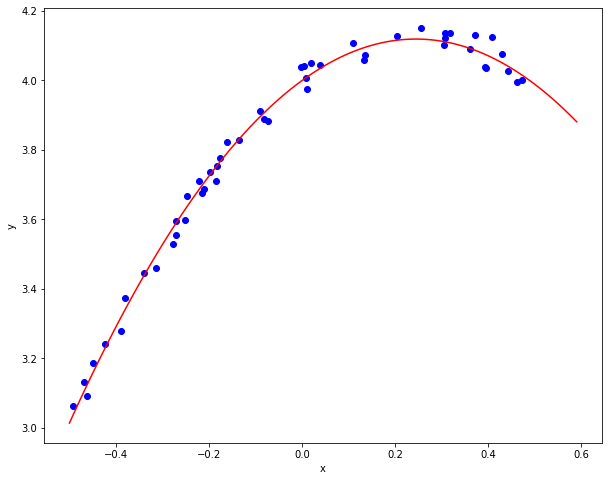

In [18]:
W = [_ for _ in pow2_model.W.parameters()]
weight = W[0].detach().cpu().numpy().reshape(-1)
print(weight)
plt.figure(3, figsize=(10, 8))
for i in range(len(data_2)):
    x, y = data_2[i]
    plt.plot(x, y, 'bo')
x = np.arange(-0.5, 0.6, 0.01)
plt.xlabel('x')
plt.ylabel('y')
plt.plot(x, weight[0] * (x ** 2) + weight[1]* x + weight[2], 'r')

Text(0, 0.5, 'loss')

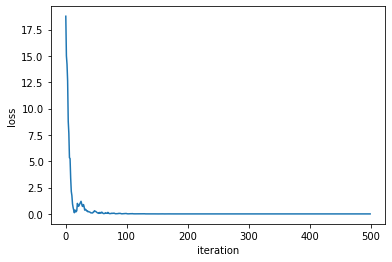

In [19]:
plt.figure(2)
plt.plot(history['iter'], history['loss'])
plt.xlabel('iteration')
plt.ylabel('loss')